### 1. Importing libraries

In [867]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

import spacy
from wordcloud import WordCloud
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

In [868]:
train = pd.read_excel('../datasets/training.xlsx', sheet_name='Sheet1')
train.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,17170,Kitchen Prep Hires Needed - Hiring ASAP!,"US, VA, Chester",NaN,NaN,NaN,BIG EVENT IN CHESTER! NOVEMBER 10TH AND 13TH!R...,NaN,NaN,0,0,0,Temporary,NaN,NaN,Restaurants,NaN,0
1,11171,Product Manager,"US, NY, New York",NaN,NaN,Gust is a global platform for the sourcing and...,"Gust, the award winning industry-leading platf...",At least three years of experience with Web/In...,NaN,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Product Management,0
2,4041,Sales Director,"US, NY, New York",NaN,60000-90000,We launched Involvio as students at Drexel Uni...,Come be one of the charter members of our sale...,4-year degree5+ years of successful performanc...,Competitive salary based on experienceStock op...,0,1,1,Full-time,Director,Bachelor's Degree,Internet,Sales,0
3,4492,Sr. Java Developer,"US, , New York",NaN,90000-120000,NaN,The Sr. Java Developer is a key team member of...,Qualifications:Bachelor’s degree in related fi...,Full Benefits.,0,0,0,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology,0
4,1481,"Senior Software Engineers, C++","GR, I, Marousi",NaN,NaN,Software Competitiveness International (SOFTCO...,Software Competitiveness International (SOFT C...,NaN,NaN,0,1,0,Full-time,NaN,NaN,Automotive,NaN,0


### 2. Describing Datasets

In [869]:
def describe_dataframe(df):
    rows = df.shape[0]
    cols = df.shape[1]

    print(f"The Training dataset has \033[1m {rows} rows\033[0m and \033[1m{cols} columns \033[0m.")

    print("\033[1m\nMissing Values\033[0m ")
    missing = [[features,df[features].isnull().sum()] for features in df.columns if df[features].isnull().sum()>0]

    for miss_val_count in missing:
        print(miss_val_count)

    fig = sns.set(rc={'figure.figsize': (8, 5)})
    plt.title("Heat Map for Missing Values")
    sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
    plt.show()

The Training dataset has  12516 rows and 18 columns .

Missing Values 
['location', 242]
['department', 8085]
['salary_range', 10500]
['company_profile', 2295]
['description', 1]
['requirements', 1874]
['benefits', 5043]
['employment_type', 2403]
['required_experience', 4948]
['required_education', 5618]
['industry', 3405]
['function', 4517]


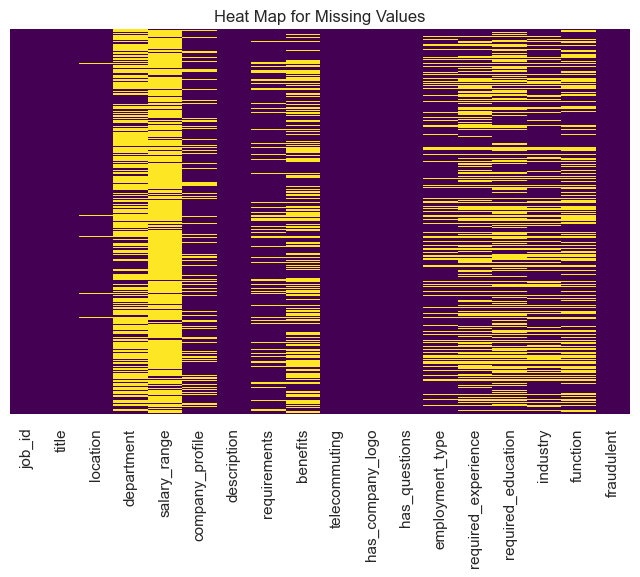

In [870]:
describe_dataframe(train)

### 3. EDA

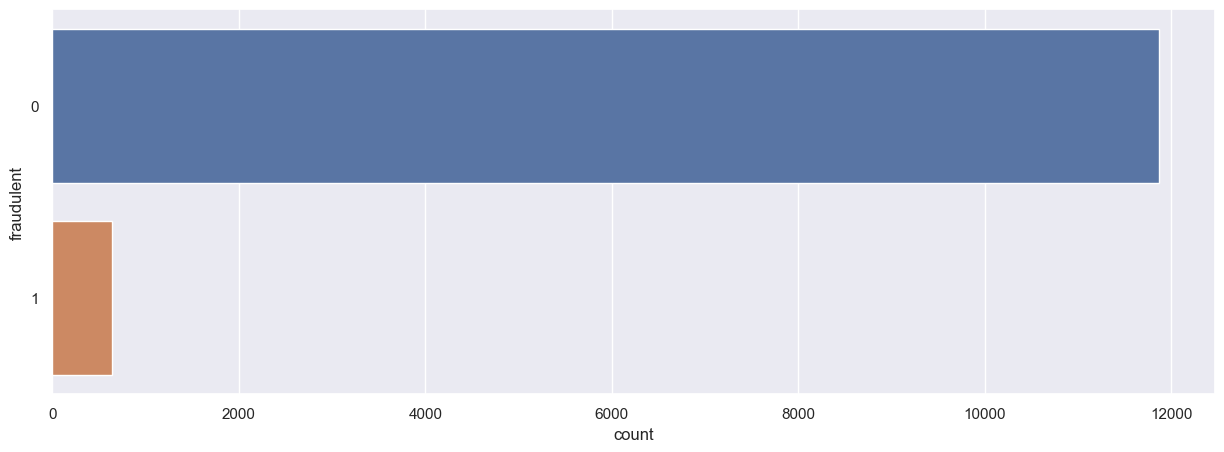

In [871]:
plt.figure(figsize=(15,5))
sns.countplot(y='fraudulent', data=train)
plt.show()

In [872]:
exp = dict(train.required_experience.value_counts())
exp_df = pd.DataFrame.from_dict(exp, orient ='index') 
exp_df.T

,Mid-Senior level,Entry level,Associate,Not Applicable,Director,Internship,Executive
0,2679,1868,1632,751,272,265,101


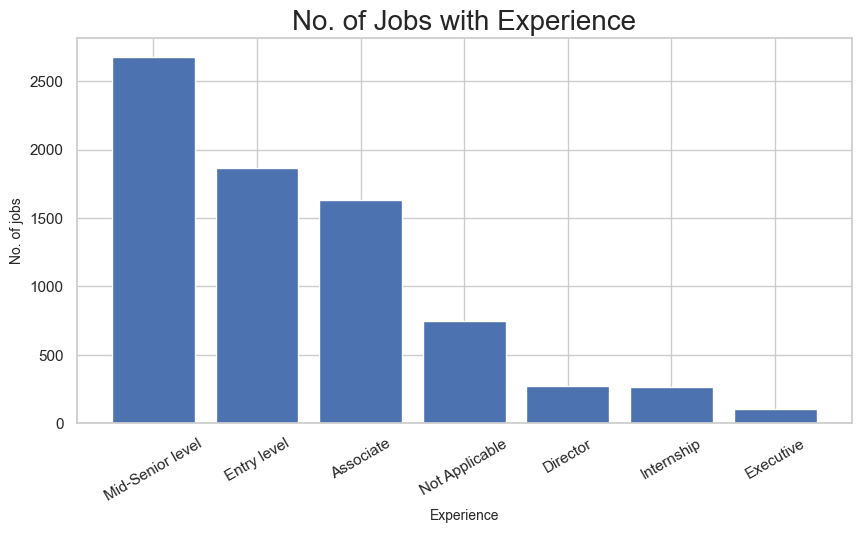

In [873]:
plt.figure(figsize=(10,5))
sns.set_theme(style="whitegrid")
plt.bar(exp.keys(),exp.values())
plt.title('No. of Jobs with Experience', size=20)
plt.xlabel('Experience',size=10)
plt.ylabel('No. of jobs',size=10)
plt.xticks(rotation=30)
plt.show()

In [874]:
edu = dict(train.required_education.value_counts()[:7])
edu

edu_df = pd.DataFrame.from_dict(edu, orient ='index') 
edu_df.T

,Bachelor's Degree,High School or equivalent,Unspecified,Master's Degree,Associate Degree,Certification,Some College Coursework Completed
0,3630,1454,988,293,203,121,72


Text(0.5, 0, 'Education')

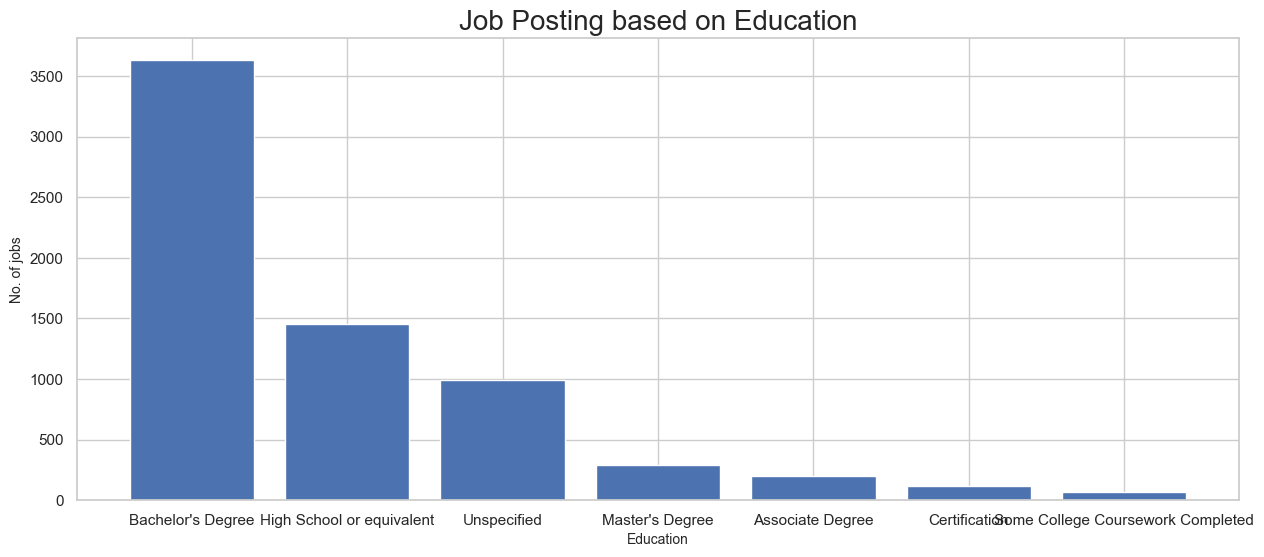

In [875]:
plt.figure(figsize=(15,6))
plt.title('Job Posting based on Education', size=20)
plt.bar(edu.keys(), edu.values())
plt.ylabel('No. of jobs', size=10)
plt.xlabel('Education', size=10)

In [876]:
print(train[train.fraudulent==1].title.value_counts()[:10])

Cruise Staff Wanted *URGENT*                                            17
Home Based Payroll Typist/Data Entry Clerks Positions Available         17
Data Entry Admin/Clerical Positions - Work From Home                    16
Administrative Assistant                                                14
Customer Service Representative                                         12
Home Based Payroll Data Entry Clerk Position - Earn $100-$200 Daily      9
Network Marketing                                                        9
Payroll Clerk                                                            7
Account Sales Managers $80-$130,000/yr                                   7
Agency Sales Managers $150-$175,000/yr                                   6
Name: title, dtype: int64


### 4. Text Preprocessing

In [877]:
concatenate_columns = ['title','company_profile','description', 'requirements', 'benefits', 'location']

remove_columns = ['job_id', 'department', 'salary_range' , 'industry']

In [878]:
def text_preprocessing(df, remove_columns, concatenate_columns):

    df[concatenate_columns[0]].fillna('-', inplace=True)
    df['text'] = concatenate_columns[0]

    for col in concatenate_columns[1:]:
        df[col].fillna('-', inplace=True)
        df['text'] = df['text'] + ' ' + df[col]

    remove_columns.extend(concatenate_columns)

    for col in remove_columns:
        del df[col]

    return df

In [879]:
train = text_preprocessing(train, remove_columns, concatenate_columns)
train.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,function,fraudulent,text
0,0,0,0,Temporary,NaN,NaN,NaN,0,title - BIG EVENT IN CHESTER! NOVEMBER 10TH AN...
1,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Product Management,0,title Gust is a global platform for the sourci...
2,0,1,1,Full-time,Director,Bachelor's Degree,Sales,0,title We launched Involvio as students at Drex...
3,0,0,0,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology,0,title - The Sr. Java Developer is a key team m...
4,0,1,0,Full-time,NaN,NaN,NaN,0,title Software Competitiveness International (...


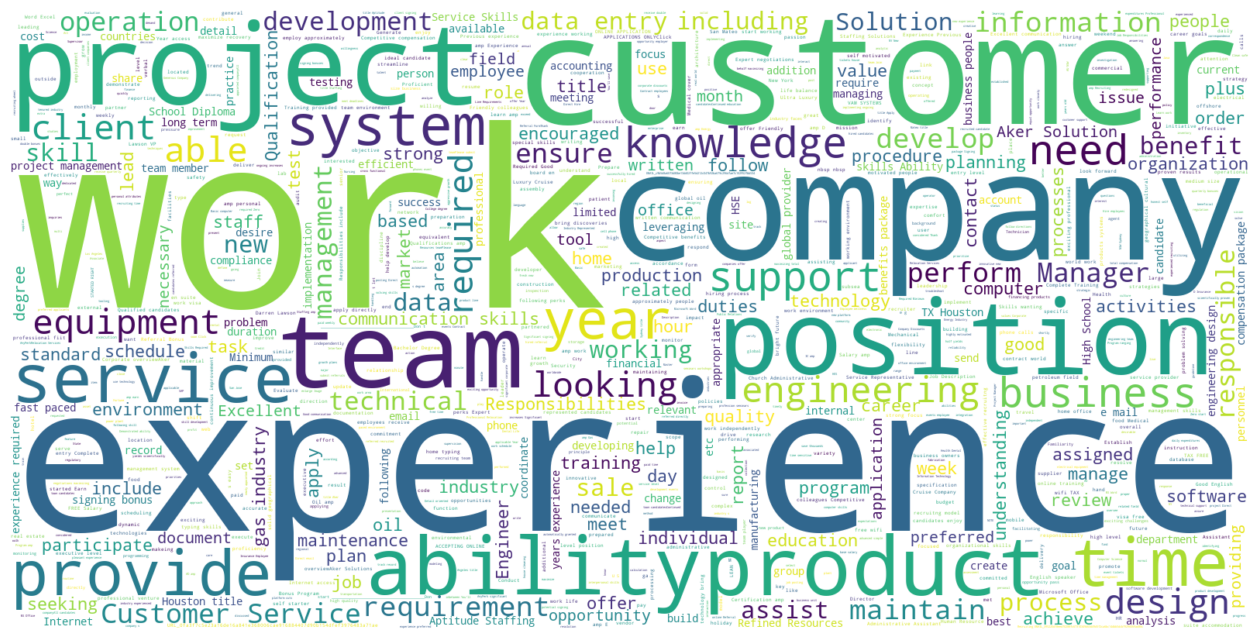

In [880]:
fraud_jobs_text = train[train.fraudulent == 1].text

STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize=(16, 14))
wc = WordCloud(min_font_size=3, max_words=3000, width=1600, height=800, stopwords=STOPWORDS,
                   background_color="white").generate(str(" ".join(fraud_jobs_text)))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [881]:
train['employment_type'].unique()

array(['Temporary', 'Full-time', nan, 'Contract', 'Part-time', 'Other'],
      dtype=object)

In [882]:
train['required_experience'].unique()

array([nan, 'Mid-Senior level', 'Director', 'Associate', 'Internship',
       'Entry level', 'Not Applicable', 'Executive'], dtype=object)

In [883]:
def categorical_processing(df):
    df['employment_type'].fillna('Not-Specified', inplace=True)

    df['employment_type'] = df['employment_type'].map({
    'Not-Specified':0,
    'Other':1,
    'Temporary':2,
    'Part-time':3,
    'Contract':4,
    'Full-time':5
    })

    df['required_experience'].fillna('Not Applicable', inplace=True)

    df['required_experience'] = df['required_experience'].map({
    'Not Applicable':0,
    'Internship':1,
    'Entry level':2,
    'Associate':3,
    'Mid-Senior level':4,
    'Executive':5,
    'Director':6,
    })

    df['required_education'].fillna('Not-Defined', inplace=True)

    df['function'].fillna('Not-Defined', inplace=True)

    temp1 = pd.get_dummies(df['required_education'])
    del df['required_education']

    #temp2 = pd.get_dummies(df['function'])
    del df['function']

    return pd.concat([temp1, df], axis=1)

In [884]:
train = categorical_processing(train)
train.head()

,Associate Degree,Bachelor's Degree,Certification,Doctorate,High School or equivalent,Master's Degree,Not-Defined,Professional,Some College Coursework Completed,Some High School Coursework,...,Vocational,Vocational - Degree,Vocational - HS Diploma,telecommuting,has_company_logo,has_questions,employment_type,required_experience,fraudulent,text
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,2,0,0,title - BIG EVENT IN CHESTER! NOVEMBER 10TH AN...
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,5,4,0,title Gust is a global platform for the sourci...
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,5,6,0,title We launched Involvio as students at Drex...
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,4,0,title - The Sr. Java Developer is a key team m...
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,5,0,0,title Software Competitiveness International (...


In [885]:
nlp = spacy.load('en_core_web_sm')

# Text Preprocessing with varoius combination

def spacy_process(text, remove_stopwords, remove_punctuation):
    
    doc = nlp(text)
    
    # Lemmatization
    lemma_list = []
    for token in doc:
        lemma_list.append(token.lemma_)
  
    # Filter the stopword

    if remove_stopwords:
        filtered_sentence =[] 
        for word in lemma_list:
            lexeme = nlp.vocab[word]
            if lexeme.is_stop == False:
                filtered_sentence.append(word)
    else:
        filtered_sentence =  lemma_list
    
    # Remove punctuation
    if remove_punctuation:
        punctuations="?:!.,;$\'-_"
        for word in filtered_sentence:
            if word in punctuations:
                filtered_sentence.remove(word)

    return " ".join(filtered_sentence)

In [886]:
# Converting Text to lowercase

def lower_text(text):
    return text.strip().lower()

In [887]:
# Creating a Dataframe with word-vectors in TF-IDF form and Target values

def final_df(df, text_column, to_lower, remove_stopwords, remove_punctuation, is_train, cv):

    # Converting Text to Lowercase
    if to_lower:
        df.loc[:,text_column] = df.loc[:,text_column].apply(lower_text)

    # Text Preprocessing with combination of stopwords and punctuations removal
    df.loc[:,text_column] = df.loc[:,text_column].apply(spacy_process, args=(remove_stopwords, remove_punctuation))

    # TF-IDF form
    if is_train:
        x = cv.fit_transform(df.loc[:,text_column])
    else:
        x = cv.transform(df.loc[:,text_column])

    # TF-IDF form to Dataframe
    temp = pd.DataFrame(x.toarray(), columns=cv.get_feature_names_out())

    # Droping the text column
    df.drop(df.loc[:,text_column].name, axis = 1, inplace=True)

    # Returning TF-IDF form with target
    return pd.concat([temp, df], axis=1)

In [888]:
# Training the model with various combination and returns y_test and y_pred

def train_model(model, train, test, target, to_lower, remove_stopwords, remove_punctuation, cv):

    # Training Preprocessing
    train = final_df(train, 'text', to_lower, remove_stopwords, remove_punctuation, True, cv)

    # Spliting training dataset
    y_train = train.loc[:,target]
    X_train = train.drop(train.loc[:,target].name, axis = 1)

    # Testing Preprocessing
    test = final_df(test, 'text', to_lower, remove_stopwords, remove_punctuation, False, cv)

    # Spliting testing dataset
    y_test = test.loc[:,target]
    X_test = test.drop(train.loc[:,target].name, axis = 1)

    # fitting the model
    model = model.fit(X_train, y_train)

    #print(roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]))
    #print(roc_auc_score(y_train, model.decision_function(X_train)))

    # calculating y_pred
    y_pred = model.predict(X_test)

    return y_test, y_pred

In [889]:
test = pd.read_excel('../datasets/testing.xlsx', sheet_name='Sheet1')
test.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,5737,Jr. Business Analyst & Quality Analyst (entry...,"US, NJ, PISCATAWAY",NaN,NaN,NaN,"Duration: Full time / W2Location: Piscataway,N...",What we require:-- Masters degree in Computers...,NaN,0,0,0,Full-time,Entry level,Master's Degree,Financial Services,Finance,0
1,7107,English Teacher Abroad,"US, PA, Scranton",NaN,NaN,We help teachers get safe &amp; secure jobs ab...,"Play with kids, get paid for it Love travel? J...",University degree required. TEFL / TESOL / CEL...,See job description,0,1,1,Contract,NaN,Bachelor's Degree,Education Management,NaN,0
2,11979,SQL Server Database Developer Job opportunity ...,"US, IL, Barrington",NaN,90000-100000,We are an innovative personnel-sourcing firm w...,Position : SQL Server Database DeveloperJob Lo...,Position : SQL Server Database DeveloperJob Lo...,Benefits - FullBonus Eligible - Yes,0,0,0,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology,0
3,9375,Legal Analyst - 12 Month FTC,"GB, LND, London",Legal,NaN,MarketInvoice is one of the most high-profile ...,DescriptionOur mission at MarketInvoice is to ...,Duties and ResponsibilitiesReviewing contractu...,Competitive salaryPrivate HealthcareHalf price...,0,1,0,Full-time,Associate,Professional,Financial Services,Legal,0
4,1301,Part-Time Finance Assistant,"GB, LND,",NaN,NaN,NaN,Salary:£9 - £10 per hour We are currently goin...,"Your role will be a varied, interesting and in...",Salary:£9 - £10 per hour,0,0,0,Part-time,NaN,NaN,Accounting,NaN,0


In [890]:
concatenate_columns = ['title','company_profile','description', 'requirements', 'benefits', 'location']

remove_columns = ['job_id', 'department', 'salary_range' , 'industry']

In [891]:
test = text_preprocessing(test, remove_columns, concatenate_columns)
test.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,function,fraudulent,text
0,0,0,0,Full-time,Entry level,Master's Degree,Finance,0,title - Duration: Full time / W2Location: Pisc...
1,0,1,1,Contract,NaN,Bachelor's Degree,NaN,0,title We help teachers get safe &amp; secure j...
2,0,0,0,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology,0,title We are an innovative personnel-sourcing ...
3,0,1,0,Full-time,Associate,Professional,Legal,0,title MarketInvoice is one of the most high-pr...
4,0,0,0,Part-time,NaN,NaN,NaN,0,title - Salary:£9 - £10 per hour We are curren...


In [892]:
test = categorical_processing(test)
test.head()

,Associate Degree,Bachelor's Degree,Certification,Doctorate,High School or equivalent,Master's Degree,Not-Defined,Professional,Some College Coursework Completed,Some High School Coursework,...,Vocational,Vocational - Degree,Vocational - HS Diploma,telecommuting,has_company_logo,has_questions,employment_type,required_experience,fraudulent,text
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,5,2,0,title - Duration: Full time / W2Location: Pisc...
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,4,0,0,title We help teachers get safe &amp; secure j...
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,4,0,title We are an innovative personnel-sourcing ...
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,5,3,0,title MarketInvoice is one of the most high-pr...
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,3,0,0,title - Salary:£9 - £10 per hour We are curren...


In [893]:
# Combination 1

# Model                 - Random Forest
# Max Features          - 10000
# Mono-Gram             - Yes
# Lowercase             - True
# Removed Stopwords     - Yes
# Removed Punctuation   - Yes

model = RandomForestClassifier(n_jobs=-1, oob_score=True, n_estimators=100, criterion="gini")
cv = TfidfVectorizer(ngram_range=(1, 1), max_features = 10000)

y_test, y_pred = train_model(model, train, test, 'fraudulent', to_lower=True, remove_stopwords=True, remove_punctuation=True, cv=cv)

score = accuracy_score(y_test, y_pred)

print("Classification Report")
print(classification_report(y_test, y_pred))

print("Accuracy Score : {:.2f} %".format(score*100))

AttributeError: 'DataFrame' object has no attribute 'name'